In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Santa Clara California 

In [18]:
data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "SantaClara"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06085/Parcels_06085.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

## Read APT data From MNR Database 

In [ ]:
apt_df = gpd.read_file(apt_data_path)
apt_df = gpd.GeoDataFrame(apt_df,crs="EPSG:4326",geometry='geometry')
apt_df = apt_df.to_crs("epsg:4326")
print("Total number of data points collected from MNR database ",apt_df.shape[0])
gc.collect()
apt_df.head()

# sns.countplot(apt_df['AnchorPoin'])
# print(apt_df['AnchorPoin'].value_counts())

# print("Building Address Points :{}".format(apt_df['AnchorPoin'].value_counts()[0] /apt_df['AnchorPoin'].count()))
# print("Address Parcel  Centroid Points:{}".format(apt_df['AnchorPoin'].value_counts()[1] /apt_df['AnchorPoin'].count() ))

## Read State Building Footprint Data

In [ ]:
# Read MIcrosoft data 
print("reading :",os.path.basename(building_geojson))
footprint_df = gpd.read_file(building_geojson)
footprint_df = gpd.GeoDataFrame(footprint_df, crs="EPSG:4326", geometry='geometry')
print("Building CRS:",footprint_df.crs)

gc.collect()
footprint_df.head()

## Read Parcel Data specific to County

In [ ]:
# read Parcel data
parcel_df = gpd.read_file(parcel_path)
parcel_df = gpd.GeoDataFrame(parcel_df,crs="EPSG:4326",geometry='geometry')
# convert parcel crs to same as building fooprint
parcel_df = parcel_df.to_crs("epsg:4326")
parcel_polygon_changedcrs_df = gpd.GeoDataFrame(geometry=parcel_df['geometry'])

print("CRS after conversion: ",parcel_df.crs)
print("Parcel Data Points :",parcel_df.shape[0])
# parcel_polygon_changedcrs_df.to_file(os.path.join(out_path,"parcel_DistrictofColumbia.geojson"), driver="GeoJSON")
gc.collect()

parcel_df.head(10)

## Process Data 

In [19]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df.head(10)

2022-08-03 15:21:42,478:INFO:- Creating Realignment-matrix for APT's
2022-08-03 15:21:42,479:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 15:37:00,878:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
0,02604077,06085,100660192_176972561,"POLYGON ((-121.90983 37.46205, -121.90995 37.4...","POLYGON ((-121.909855 37.462099, -121.909799 3...","POLYGON ((-121.90985 37.46210, -121.90980 37.4...",POINT (-121.90982 37.46220),000055433300280000000000006538d6,Latn,ENG,...,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,POINT (-121.90974 37.462187)
2,02604074,06085,100660192_176972563,"POLYGON ((-121.91049 37.46181, -121.91059 37.4...","POLYGON ((-121.910477 37.461879, -121.910327 3...","POLYGON ((-121.91048 37.46188, -121.91033 37.4...",POINT (-121.91043 37.46197),000055433300280000000000006538ce,Latn,ENG,...,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,POINT (-121.910396 37.461946)
3,02604076,06085,100660192_176972560,"POLYGON ((-121.91003 37.46196, -121.91016 37.4...","POLYGON ((-121.909917 37.462073, -121.909991 3...","POLYGON ((-121.90992 37.46207, -121.90999 37.4...",POINT (-121.91003 37.46212),000055433300280000000000006538d2,Latn,ENG,...,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,POINT (-121.909937 37.462111)
4,02604118,06085,100660192_176972559,"POLYGON ((-121.91099 37.46168, -121.91108 37.4...","POLYGON ((-121.91099 37.46179, -121.910947 37....","POLYGON ((-121.91099 37.46179, -121.91095 37.4...",POINT (-121.91089 37.46183),000055433300280000000000006538ae,Latn,ENG,...,CA,Milpitas,Arizona Ave,USA,None,Ave,None,None,Arizona,POINT (-121.910822 37.461753)
4,02604118,06085,100660192_176972559,"POLYGON ((-121.91099 37.46168, -121.91108 37.4...","POLYGON ((-121.91099 37.46179, -121.910947 37....","POLYGON ((-121.91099 37.46179, -121.91095 37.4...",POINT (-121.91089 37.46183),000055433300280000000000006538af,Latn,ENG,...,CA,Milpitas,Arizona Ave,USA,None,Ave,None,None,Arizona,POINT (-121.910867 37.461848)
5,02604117,06085,100660192_176972558,"POLYGON ((-121.91108 37.46184, -121.91121 37.4...","POLYGON ((-121.911102 37.461992, -121.911055 3...","POLYGON ((-121.91110 37.46199, -121.91106 37.4...",POINT (-121.91100 37.46196),000055433300280000000000006538b0,Latn,ENG,...,CA,Milpitas,Arizona Ave,USA,None,Ave,None,None,Arizona,POINT (-121.910863 37.461969)
9,02604111,06085,100660192_176972554,"POLYGON ((-121.91007 37.46238, -121.91019 37.4...","POLYGON ((-121.910145 37.462557, -121.910088 3...","POLYGON ((-121.91014 37.46256, -121.91009 37.4...",POINT (-121.91004 37.46254),000055433300280000000000006538d7,Latn,ENG,...,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,POINT (-121.909939 37.46244)
22,12733047,06085,100660192_176981944,"POLYGON ((-122.12667 37.43620, -122.12682 37.4...","POLYGON ((-122.126641 37.436455, -122.126621 3...","POLYGON ((-122.12664 37.43646, -122.12662 37.4...",POINT (-122.12660 37.43640),0000554333002800000000000064c95f,Latn,ENG,...,CA,Palo Alto,Marshall Dr,USA,None,Dr,None,None,Marshall,POINT (-122.126565 37.436412)
23,12728031,06085,100660192_176981943,"POLYGON ((-122.12615 37.43644, -122.12616 37.4...","POLYGON ((-122.126161 37.436579, -122.126077 3...","POLYGON ((-122.12616 37.43658, -122.12608 37.4...",POINT (-122.12619 37.43664),0000554333002800000000000064c965,Latn,ENG,...,CA,Palo Alto,Bruce Dr,USA,None,Dr,None,None,Bruce,POINT (-122.1261 37.436642)
25,12728100,06085,100660192_176981941,"POLYGON ((-122.12410 37.43651, -122.12438 37.4...","POLYGON ((-122.124034 37.436644, -122.124144 3...","POLYGON ((-122.12403 37.43664, -122.12414 37.4...",POINT (-122.12415 37.43668),0000554333002800000000000064e160,Latn,ENG,...,CA,Palo Alto,Sycamore Dr,USA,None,Dr,None,None,Sycamore,POINT (-122.124145 37.436708)


In [20]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df['APT_to_Centroid_distance'] = processed_df.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df['APT_lat'] = processed_df['APT'].apply(lambda z: z.y)
processed_df['APT_lon'] = processed_df['APT'].apply(lambda z: z.x)

processed_df['updated_lat'] = processed_df['updated_geometries'].apply(lambda z: z.y)
processed_df['updated_lon'] = processed_df['updated_geometries'].apply(lambda z: z.x)
processed_df.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,02604077,06085,100660192_176972561,"POLYGON ((-121.90983 37.46205, -121.90995 37.4...","POLYGON ((-121.909855 37.462099, -121.909799 3...","POLYGON ((-121.90985 37.46210, -121.90980 37.4...",POINT (-121.90982 37.46220),000055433300280000000000006538d6,Latn,ENG,...,St,None,None,Buskirk,POINT (-121.90974 37.462187),7.1,37.462187,-121.909740,37.462196,-121.909821
2,02604074,06085,100660192_176972563,"POLYGON ((-121.91049 37.46181, -121.91059 37.4...","POLYGON ((-121.910477 37.461879, -121.910327 3...","POLYGON ((-121.91048 37.46188, -121.91033 37.4...",POINT (-121.91043 37.46197),000055433300280000000000006538ce,Latn,ENG,...,St,None,None,Buskirk,POINT (-121.910396 37.461946),4.2,37.461946,-121.910396,37.461972,-121.910432
3,02604076,06085,100660192_176972560,"POLYGON ((-121.91003 37.46196, -121.91016 37.4...","POLYGON ((-121.909917 37.462073, -121.909991 3...","POLYGON ((-121.90992 37.46207, -121.90999 37.4...",POINT (-121.91003 37.46212),000055433300280000000000006538d2,Latn,ENG,...,St,None,None,Buskirk,POINT (-121.909937 37.462111),8.2,37.462111,-121.909937,37.462120,-121.910030
4,02604118,06085,100660192_176972559,"POLYGON ((-121.91099 37.46168, -121.91108 37.4...","POLYGON ((-121.91099 37.46179, -121.910947 37....","POLYGON ((-121.91099 37.46179, -121.91095 37.4...",POINT (-121.91089 37.46183),000055433300280000000000006538ae,Latn,ENG,...,Ave,None,None,Arizona,POINT (-121.910822 37.461753),10.5,37.461753,-121.910822,37.461828,-121.910895
4,02604118,06085,100660192_176972559,"POLYGON ((-121.91099 37.46168, -121.91108 37.4...","POLYGON ((-121.91099 37.46179, -121.910947 37....","POLYGON ((-121.91099 37.46179, -121.91095 37.4...",POINT (-121.91089 37.46183),000055433300280000000000006538af,Latn,ENG,...,Ave,None,None,Arizona,POINT (-121.910867 37.461848),3.2,37.461848,-121.910867,37.461828,-121.910895


In [ ]:
# out_path = os.path.join(data_path,city)
# save_geometry(processed_df,geometry='updated_geometries',out_path=out_path,fname='APT_usa_uca_updated_gemotries.geojson')
# save_geometry(processed_df,geometry='APT',out_path=out_path,fname='APT_usa_uca.geojson')
# save_geometry(processed_df,geometry='building_geometry',out_path=out_path,fname='building_roi_usa_ua.geojson')

In [21]:
distance_greater_than_50m = processed_df.loc[processed_df['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df.shape[0])))

Max distance APT from Parcel to Building Centroid 1163.10 m
Data points greater than 50m: 0.31% 


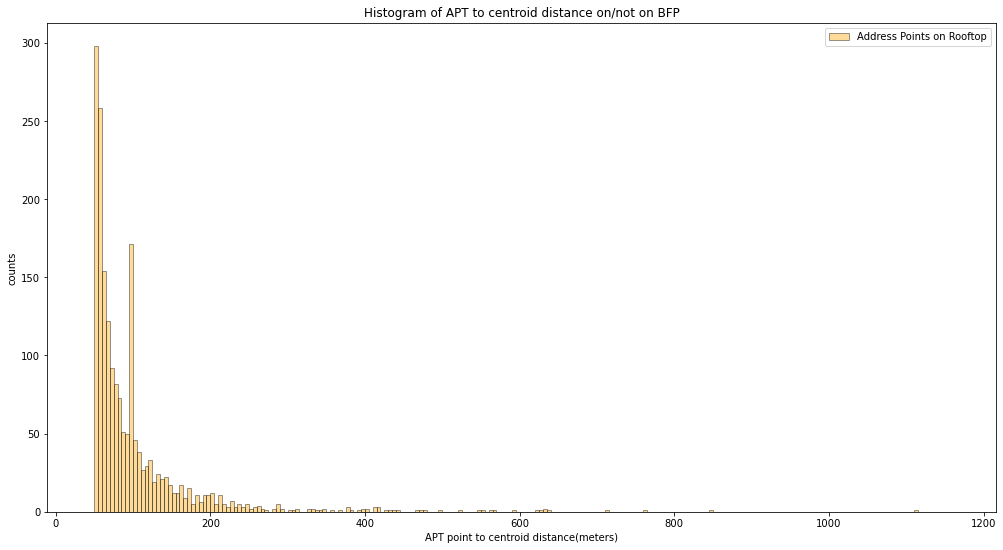

14860

In [22]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [23]:
df_for_analysis_usa_co_arapahoe = processed_df.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_arapahoe.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,POINT (-121.90982 37.46220),000055433300280000000000006538d6,Latn,ENG,95035,154,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,7.1,37.462187,-121.909740,37.462196,-121.909821
2,POINT (-121.91043 37.46197),000055433300280000000000006538ce,Latn,ENG,95035,118,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,4.2,37.461946,-121.910396,37.461972,-121.910432
3,POINT (-121.91003 37.46212),000055433300280000000000006538d2,Latn,ENG,95035,142,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,8.2,37.462111,-121.909937,37.462120,-121.910030
4,POINT (-121.91089 37.46183),000055433300280000000000006538ae,Latn,ENG,95035,2123,CA,Milpitas,Arizona Ave,USA,None,Ave,None,None,Arizona,10.5,37.461753,-121.910822,37.461828,-121.910895
4,POINT (-121.91089 37.46183),000055433300280000000000006538af,Latn,ENG,95035,2135,CA,Milpitas,Arizona Ave,USA,None,Ave,None,None,Arizona,3.2,37.461848,-121.910867,37.461828,-121.910895


In [26]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
if not os.path.isdir(output_path):
    os.makedirs(output_path)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_co_arapahoe, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_usa_uca_SC.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)

## Araphoe Colarado  

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Colorado"
city = "Arapahoe"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_uco.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_08005/Parcels_08005.shp")
building_geojson = os.path.join(data_path,state,'Colorado.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [5]:
# if os.path.isfile(parcel_path):
#     mnr_database = extract_mnr_data(country_code='_2022_06_010_nam_usa_uco')
#     mnr_database.connect_to_server()
#     # out_path = os.path.join(data_path,state)
#     # mnr_apt_df = mnr_database.extract_apt_addresses_data()
#     # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_uco.shp')

gc.collect()

3753

In [6]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_co = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_co.head(10)

2022-08-03 20:06:26,444:INFO:- Creating Realignment-matrix for APT's
2022-08-03 20:06:26,446:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 20:10:08,460:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
0,1971-35-3-23-043,08005,100660192_205096966,"POLYGON ((-104.97765 39.65356, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65356, -104.97811 39.6...",POINT (-104.97790 39.65364),00004358-3100-2800-0000-00000003efbe,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977889 39.653629)
1,1971-35-3-23-044,08005,100660192_205096967,"POLYGON ((-104.97765 39.65336, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65336, -104.97811 39.6...",POINT (-104.97790 39.65347),00004358-3100-2800-0000-00000003efbd,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977889 39.65346)
2,1971-35-3-23-045,08005,100660192_205096968,"POLYGON ((-104.97765 39.65322, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97811 39.65336, -104.97769 39.6...",POINT (-104.97789 39.65333),00004358-3100-2800-0000-00000003efbc,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977892 39.653288)
3,1971-35-3-23-032,08005,100660192_205096969,"POLYGON ((-104.97765 39.65322, -104.97765 39.6...","POLYGON ((-104.977599 39.653904, -104.977604 3...","POLYGON ((-104.97760 39.65364, -104.97716 39.6...",POINT (-104.97738 39.65345),00004358-3100-2800-0000-00000003efd5,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.977386 39.653425)
4,1971-35-3-23-042,08005,100660192_205096965,"POLYGON ((-104.97765 39.65370, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65370, -104.97811 39.6...",POINT (-104.97790 39.65377),00004358-3100-2800-0000-00000003efbf,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.97789 39.653767)
5,1971-35-3-23-041,08005,100660192_205096964,"POLYGON ((-104.97765 39.65384, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65384, -104.97811 39.6...",POINT (-104.97790 39.65389),00004358-3100-2800-0000-00000003efc0,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977888 39.653908)
7,1971-35-3-24-015,08005,100660192_205096956,"POLYGON ((-104.97636 39.65415, -104.97692 39.6...","POLYGON ((-104.976447 39.654674, -104.976592 3...","POLYGON ((-104.97645 39.65467, -104.97659 39.6...",POINT (-104.97663 39.65445),00004358-3100-2800-0000-00000003f051,Latn,ENG,...,CO,Englewood,S Emerson St,USA,None,St,S,None,Emerson,POINT (-104.976653 39.654503)
11,1971-35-3-20-005,08005,100660192_205096945,"POLYGON ((-104.97531 39.65584, -104.97576 39.6...","POLYGON ((-104.975564 39.655855, -104.975565 3...","POLYGON ((-104.97556 39.65586, -104.97557 39.6...",POINT (-104.97562 39.65591),00004358-3100-2800-0000-00000003f0d0,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756031 39.6559106)
12,1971-34-4-00-057,08005,100660192_205096963,"POLYGON ((-104.97902 39.65323, -104.97902 39.6...","POLYGON ((-104.978445 39.65328, -104.978445 39...","POLYGON ((-104.97844 39.65328, -104.97844 39.6...",POINT (-104.97870 39.65350),00004358-3100-2800-0000-00000003efbb,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.978684 39.653433)
13,1971-34-4-00-052,08005,100660192_205096962,"POLYGON ((-104.97969 39.65323, -104.97969 39.6...","POLYGON ((-104.979094 39.653342, -104.979093 3...","POLYGON ((-104.97909 39.65334, -104.97909 39.6...",POINT (-104.97933 39.65351),00004358-3100-2800-0000-00000003efba,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.979344 39.653476)


In [7]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_co['APT_to_Centroid_distance'] = processed_df_co.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_co['APT_lat'] = processed_df_co['APT'].apply(lambda z: z.y)
processed_df_co['APT_lon'] = processed_df_co['APT'].apply(lambda z: z.x)

processed_df_co['updated_lat'] = processed_df_co['updated_geometries'].apply(lambda z: z.y)
processed_df_co['updated_lon'] = processed_df_co['updated_geometries'].apply(lambda z: z.x)
processed_df_co.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,1971-35-3-23-043,08005,100660192_205096966,"POLYGON ((-104.97765 39.65356, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65356, -104.97811 39.6...",POINT (-104.97790 39.65364),00004358-3100-2800-0000-00000003efbe,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977889 39.653629),1.2,39.653629,-104.977889,39.653636,-104.977900
1,1971-35-3-23-044,08005,100660192_205096967,"POLYGON ((-104.97765 39.65336, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65336, -104.97811 39.6...",POINT (-104.97790 39.65347),00004358-3100-2800-0000-00000003efbd,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977889 39.65346),1.2,39.653460,-104.977889,39.653465,-104.977902
2,1971-35-3-23-045,08005,100660192_205096968,"POLYGON ((-104.97765 39.65322, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97811 39.65336, -104.97769 39.6...",POINT (-104.97789 39.65333),00004358-3100-2800-0000-00000003efbc,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977892 39.653288),4.2,39.653288,-104.977892,39.653326,-104.977892
3,1971-35-3-23-032,08005,100660192_205096969,"POLYGON ((-104.97765 39.65322, -104.97765 39.6...","POLYGON ((-104.977599 39.653904, -104.977604 3...","POLYGON ((-104.97760 39.65364, -104.97716 39.6...",POINT (-104.97738 39.65345),00004358-3100-2800-0000-00000003efd5,Latn,ENG,...,Ave,None,None,Hampden,POINT (-104.977386 39.653425),2.6,39.653425,-104.977386,39.653449,-104.977383
4,1971-35-3-23-042,08005,100660192_205096965,"POLYGON ((-104.97765 39.65370, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65370, -104.97811 39.6...",POINT (-104.97790 39.65377),00004358-3100-2800-0000-00000003efbf,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.97789 39.653767),1.1,39.653767,-104.977890,39.653774,-104.977899


In [8]:
distance_greater_than_50m = processed_df_co.loc[processed_df_co['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_co.shape[0])))

Max distance APT from Parcel to Building Centroid 1076.50 m
Data points greater than 50m: 0.72% 


In [12]:
df_for_analysis_usa_co_arapahoe = processed_df_co.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_arapahoe.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,POINT (-104.97790 39.65364),00004358-3100-2800-0000-00000003efbe,Latn,ENG,80113,3472,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.2,39.653629,-104.977889,39.653636,-104.977900
1,POINT (-104.97790 39.65347),00004358-3100-2800-0000-00000003efbd,Latn,ENG,80113,3488,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.2,39.653460,-104.977889,39.653465,-104.977902
2,POINT (-104.97789 39.65333),00004358-3100-2800-0000-00000003efbc,Latn,ENG,80113,3490,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,4.2,39.653288,-104.977892,39.653326,-104.977892
3,POINT (-104.97738 39.65345),00004358-3100-2800-0000-00000003efd5,Latn,ENG,80113,851,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,2.6,39.653425,-104.977386,39.653449,-104.977383
4,POINT (-104.97790 39.65377),00004358-3100-2800-0000-00000003efbf,Latn,ENG,80113,3466,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.1,39.653767,-104.977890,39.653774,-104.977899


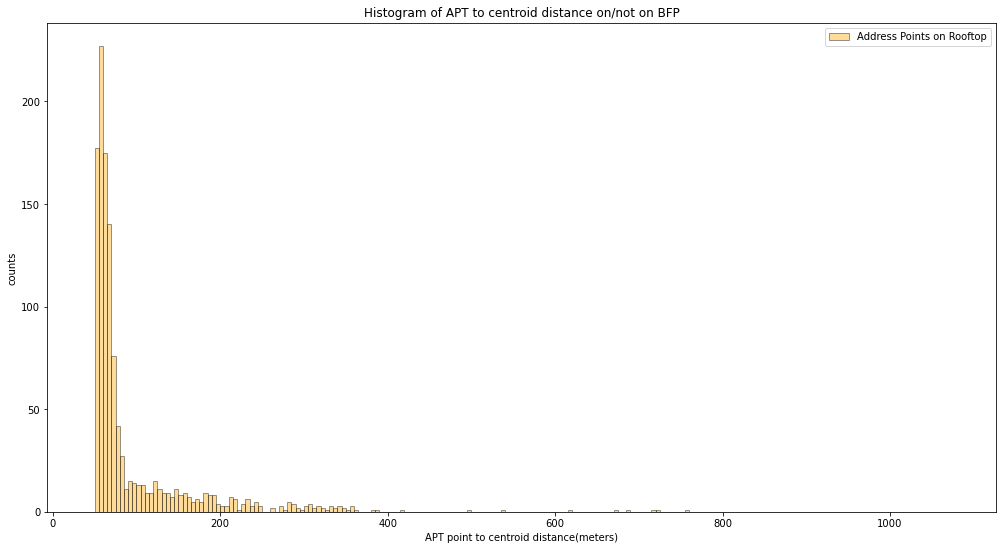

14983

In [13]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [14]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
if not os.path.isdir:
    os.makedirs(output_path)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_co_arapahoe, geometry='updated_geometries', crs="EPSG:4326")
pd_dataframe = pd.DataFrame(geo_dataframe)
pd_dataframe.to_pickle(os.path.join(output_path,"APT_realigned_usa_uco_araphoe.pkl"))

filename = os.path.join(output_path,'APT_realigned_usa_uco_araphoe.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)

## Miamidade_Florida

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data


data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Florida"
city = "Miamidade"

apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12086/Parcels_12086.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [24]:
if not os.path.isfile(apt_data_path):
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ufl')
    mnr_database.connect_to_server()
    # out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ufl.shp')

In [2]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_miamidade = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_miamidade.head(5)

KeyboardInterrupt: 

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_miamidade['APT_to_Centroid_distance'] = processed_df_miamidade.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)
processed_df_miamidade['APT_lat'] = processed_df_miamidade['APT'].apply(lambda z: z.y)
processed_df_miamidade['APT_long'] = processed_df_miamidade['APT'].apply(lambda z: z.x)

processed_df_miamidade['updated_lat'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.y)
processed_df_miamidade['updated_lon'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.x)
processed_df_miamidade.head()

In [ ]:
distance_greater_than_50m = processed_df_miamidade.loc[processed_df_miamidade['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_miamidade.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>=50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Disstance from Building Centroid',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis_usa_fl = processed_df_miamidade.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_fl.head()

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
# print(output_path)
if not os.path.isdir:
    os.makedirs(output_path)
geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_fl, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_usa_ufl_miamidade.shp')

pd_dataframe = pd.DataFrame(geo_dataframe)
pd_dataframe.to_pickle(os.path.join(output_path,"APT_realigned_usa_uufl_miamidade.pkl"))

geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)


## Duval_Florida

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/"
state = "Florida"
city = "Duval"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12031/Parcels_12031.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_duval = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_duval.head(10)

2022-08-03 09:52:37,236:INFO:- Creating Realignment-matrix for APT's
2022-08-03 09:52:37,236:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 09:59:33,229:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
1,0195520270R,12031,100660192_22021635,"POLYGON ((-81.74024 30.52834, -81.74049 30.528...","POLYGON ((-81.73952 30.528959, -81.739555 30.5...","POLYGON ((-81.73952 30.52896, -81.73955 30.529...",POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.73984900000001 30.528775)
3,0195870244R,12031,100660192_22021627,"POLYGON ((-81.74387 30.52774, -81.74422 30.528...","POLYGON ((-81.74365400000001 30.528007, -81.74...","POLYGON ((-81.74365 30.52801, -81.74354 30.528...",POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.743289 30.528184)
4,0195870230R,12031,100660192_22021626,"POLYGON ((-81.74422 30.52813, -81.74450 30.528...","POLYGON ((-81.743807 30.528454, -81.743832 30....","POLYGON ((-81.74381 30.52845, -81.74383 30.528...",POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.743526 30.528635)
5,0195520120R,12031,100660192_22021625,"POLYGON ((-81.73911 30.52914, -81.73947 30.529...","POLYGON ((-81.739011 30.529489, -81.739045 30....","POLYGON ((-81.73901 30.52949, -81.73905 30.529...",POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.738508 30.52961)
6,0195520250R,12031,100660192_22021640,"POLYGON ((-81.73965 30.52765, -81.74020 30.528...","POLYGON ((-81.739788 30.528179, -81.739749 30....","POLYGON ((-81.73979 30.52818, -81.73975 30.528...",POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.739389 30.528248)
9,0195870210R,12031,100660192_22021614,"POLYGON ((-81.74225 30.52863, -81.74227 30.528...","POLYGON ((-81.74181799999999 30.528895, -81.74...","POLYGON ((-81.74182 30.52889, -81.74172 30.528...",POINT (-81.74186 30.52900),0000554631002800000000000007290f,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.741941 30.529352)
13,0195520280R,12031,100660192_22021636,"POLYGON ((-81.74057 30.52871, -81.74093 30.529...","POLYGON ((-81.74078799999999 30.528969, -81.74...","POLYGON ((-81.74079 30.52897, -81.74071 30.528...",POINT (-81.74073 30.52905),00005546310028000000000000072910,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.740183 30.529082)
16,0195990035R,12031,100660192_22023165,"POLYGON ((-81.64814 30.52886, -81.64922 30.529...","POLYGON ((-81.649278 30.529937, -81.649095 30....","POLYGON ((-81.64928 30.52994, -81.64910 30.529...",POINT (-81.64915 30.52993),fb34bd8fcf8d4027abac41ad3bf4239c,Latn,ENG,...,FL,Jacksonville,Williams Oak Dr,USA,None,Dr,None,None,Williams Oak,POINT (-81.64885700000001 30.529508)
18,1081140030R,12031,100660192_22023156,"POLYGON ((-81.64812 30.52716, -81.64812 30.527...","POLYGON ((-81.647007 30.529535, -81.6470049999...","POLYGON ((-81.64701 30.52953, -81.64700 30.529...",POINT (-81.64688 30.52948),00005546310028000000000001325dee,Latn,ENG,...,FL,Jacksonville,Butch Baine Dr E,USA,None,Dr,None,E,Butch Baine,POINT (-81.64767999999999 30.529939)
21,1061180005R,12031,100660192_22023152,"POLYGON ((-81.63158 30.54226, -81.63118 30.542...","POLYGON ((-81.627889 30.542662, -81.627804 30....","POLYGON ((-81.62789 30.54266, -81.62780 30.542...",POINT (-81.62781 30.54277),bd466a9b7e7447009b699aa544598767,Latn,ENG,...,FL,Jacksonville,Carter Trl,USA,None,Trl,None,None,Carter,POINT (-81.62992199999999 30.542732)


In [3]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_duval['APT_to_Centroid_distance'] = processed_df_duval.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_duval['APT_lat'] = processed_df_duval['APT'].apply(lambda z: z.y)
processed_df_duval['APT_long'] = processed_df_duval['APT'].apply(lambda z: z.x)

processed_df_duval['updated_lat'] = processed_df_duval['updated_geometries'].apply(lambda z: z.y)
processed_df_duval['updated_long'] = processed_df_duval['updated_geometries'].apply(lambda z: z.x)

processed_df_duval.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_long
1,0195520270R,12031,100660192_22021635,"POLYGON ((-81.74024 30.52834, -81.74049 30.528...","POLYGON ((-81.73952 30.528959, -81.739555 30.5...","POLYGON ((-81.73952 30.52896, -81.73955 30.529...",POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.73984900000001 30.528775),35.3,30.528775,-81.739849,30.529010,-81.739601
3,0195870244R,12031,100660192_22021627,"POLYGON ((-81.74387 30.52774, -81.74422 30.528...","POLYGON ((-81.74365400000001 30.528007, -81.74...","POLYGON ((-81.74365 30.52801, -81.74354 30.528...",POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,...,Trl,None,None,Puskita,POINT (-81.743289 30.528184),32.2,30.528184,-81.743289,30.528118,-81.743616
4,0195870230R,12031,100660192_22021626,"POLYGON ((-81.74422 30.52813, -81.74450 30.528...","POLYGON ((-81.743807 30.528454, -81.743832 30....","POLYGON ((-81.74381 30.52845, -81.74383 30.528...",POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,...,Trl,None,None,Puskita,POINT (-81.743526 30.528635),40.7,30.528635,-81.743526,30.528461,-81.743900
5,0195520120R,12031,100660192_22021625,"POLYGON ((-81.73911 30.52914, -81.73947 30.529...","POLYGON ((-81.739011 30.529489, -81.739045 30....","POLYGON ((-81.73901 30.52949, -81.73905 30.529...",POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.738508 30.52961),55.8,30.529610,-81.738508,30.529523,-81.739082
6,0195520250R,12031,100660192_22021640,"POLYGON ((-81.73965 30.52765, -81.74020 30.528...","POLYGON ((-81.739788 30.528179, -81.739749 30....","POLYGON ((-81.73979 30.52818, -81.73975 30.528...",POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.739389 30.528248),30.6,30.528248,-81.739389,30.528216,-81.739707


In [14]:
distance_greater_than_50m = processed_df_duval.loc[processed_df_duval['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_duval.shape[0])))

Max distance APT from Parcel to Building Centroid 1243.10 m
Data points greater than 50m: 1.87%


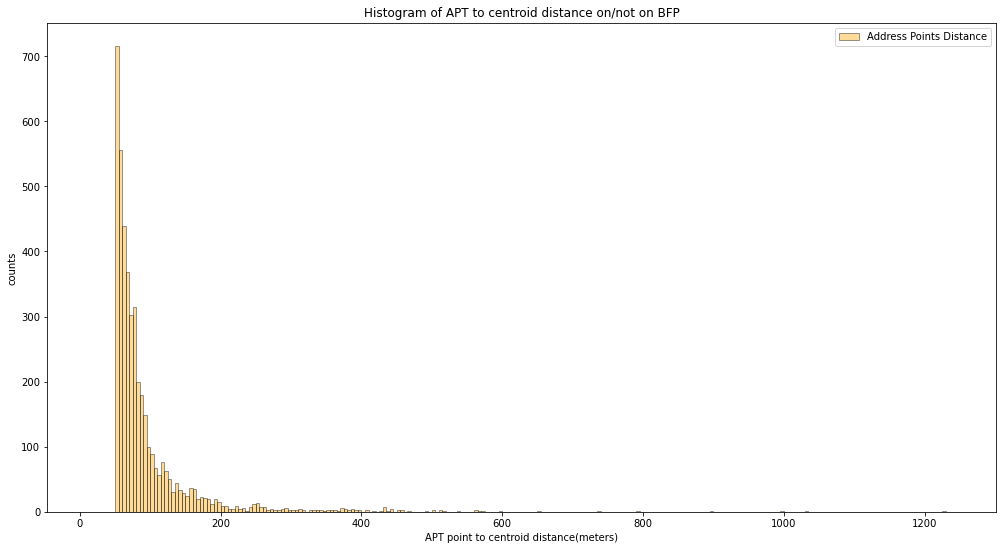

17424

In [16]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>=50].values, bins = np.arange(15,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Distance',color='orange')

plt.legend()
plt.show()
gc.collect()

In [17]:
df_for_analysis_usa_duval = processed_df_duval.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_duval.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_long
1,POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,32218,16050,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,35.3,30.528775,-81.739849,30.529010,-81.739601
3,POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,32218,16066,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,32.2,30.528184,-81.743289,30.528118,-81.743616
4,POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,32218,16070,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,40.7,30.528635,-81.743526,30.528461,-81.743900
5,POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,32218,16055,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,55.8,30.529610,-81.738508,30.529523,-81.739082
6,POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,32218,16044,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,30.6,30.528248,-81.739389,30.528216,-81.739707


In [18]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
os.makedirs(output_path,exist_ok=True)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_duval, geometry='updated_geometries', crs="EPSG:4326")
pd_dataframe = pd.DataFrame(geo_dataframe)
filename = os.path.join(output_path,'APT_realigned_2022_06_009_nam_usa_ufl_duval')

pd_dataframe.to_pickle(filename+'.pkl')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename+'.shp')


In [ ]:
## Downloa

## Harris Texas

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Georgia"
city = "Harris"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_utx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_48201/Parcels_48201.shp")
building_geojson = os.path.join(data_path,state,'Texas.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
if not os.path.isfile(apt_data_path):
    print("downloading .. ")
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ugx')
    mnr_database.connect_to_server()

    out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ugx.shp')

In [2]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_harris = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_harris.head(10)

2022-08-03 20:45:02,843:INFO:- Creating Realignment-matrix for APT's
2022-08-03 20:45:02,846:INFO:- Processing Land Parcel data and Building Footprints 
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -95.393144652938659 29.734641588151117 at -95.393144652938659 29.734641588151117
ERROR:root:error for POLYGON ((-95.393619 29.735207, -95.393613 29.734997, -95.39355999999999 29.734998, -95.393558 29.734931, -95.393619 29.734929, -95.39361599999999 29.734799, -95.393449 29.734803, -95.393452 29.734905, -95.39337999999999 29.734907, -95.393377 29.73479, -95.393208 29.734794, -95.393208 29.734804, -95.393154 29.734805, -95.393156 29.734869, -95.39331199999999 29.734866, -95.393315 29.734978, -95.393208 29.73498, -95.393213 29.735183, -95.393315 29.73518, -95.393316 29.735213, -95.393619 29.735207)),POLYGON ((-95.39361440110633 29.73453757852242, -95.39361447478713 29.73455827817068, -95.39353177724564 29.73455921723125, -95.39353403592723 29.7345737320807

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
2,1353140010005,48201,512482743_10,"POLYGON ((-95.90885 30.07116, -95.90887 30.071...","POLYGON ((-95.90847599999999 30.071622, -95.90...","POLYGON ((-95.90848 30.07162, -95.90847 30.071...",POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,Latn,ENG,...,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,POINT (-95.906471 30.071253)
3,1353140010002,48201,512482743_9,"POLYGON ((-95.90885 30.07116, -95.90887 30.071...","POLYGON ((-95.90847599999999 30.071622, -95.90...","POLYGON ((-95.90848 30.07162, -95.90847 30.071...",POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,Latn,ENG,...,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,POINT (-95.906471 30.071253)
4,1353140010004,48201,512482743_8,"POLYGON ((-95.90595 30.07028, -95.90634 30.071...","POLYGON ((-95.908168 30.072129, -95.908519 30....","POLYGON ((-95.90817 30.07213, -95.90852 30.072...",POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,Latn,ENG,...,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,POINT (-95.905479 30.0714)
5,1353140010001,48201,512482743_7,"POLYGON ((-95.90595 30.07028, -95.90634 30.071...","POLYGON ((-95.908168 30.072129, -95.908519 30....","POLYGON ((-95.90817 30.07213, -95.90852 30.072...",POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,Latn,ENG,...,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,POINT (-95.905479 30.0714)
16,0420390000001,48201,100660192_219098542,"POLYGON ((-95.88178 30.11387, -95.88188 30.121...","POLYGON ((-95.87925300000001 30.115562, -95.87...","POLYGON ((-95.87925 30.11556, -95.87943 30.115...",POINT (-95.87934 30.11551),00005554-3500-2800-0000-000000f054e5,Latn,ENG,...,TX,Waller,Kickapoo Rd,USA,None,Rd,None,None,Kickapoo,POINT (-95.880273 30.117724)
17,0420390000005,48201,100660192_219098543,"POLYGON ((-95.88178 30.11387, -95.88188 30.121...","POLYGON ((-95.87925300000001 30.115562, -95.87...","POLYGON ((-95.87925 30.11556, -95.87943 30.115...",POINT (-95.87934 30.11551),00005554-3500-2800-0000-000000f054e5,Latn,ENG,...,TX,Waller,Kickapoo Rd,USA,None,Rd,None,None,Kickapoo,POINT (-95.880273 30.117724)
24,0460580000107,48201,100660192_219098529,"POLYGON ((-95.91048 30.06886, -95.91050 30.069...","POLYGON ((-95.90979 30.069301, -95.90978699999...","POLYGON ((-95.90979 30.06930, -95.90979 30.069...",POINT (-95.90964 30.06924),00005554-3500-2800-0000-000000f651bb,Latn,ENG,...,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,POINT (-95.90978 30.069114)
35,0402200010191,48201,100660192_219104346,"POLYGON ((-95.68218 30.09897, -95.68218 30.099...","POLYGON ((-95.68177300000001 30.099211, -95.68...","POLYGON ((-95.68177 30.09921, -95.68182 30.099...",POINT (-95.68185 30.09914),00005554-3500-2800-0000-000000f57e13,Latn,ENG,...,TX,Tomball,Kobs Rd,USA,None,Rd,None,None,Kobs,POINT (-95.68167819999999 30.0990929)
36,0402200010104,48201,100660192_219104347,"POLYGON ((-95.68116 30.09839, -95.68116 30.098...","POLYGON ((-95.680719 30.098975, -95.68073 30.0...","POLYGON ((-95.68072 30.09897, -95.68073 30.099...",POINT (-95.68088 30.09901),00005554-3500-2800-0000-000000f0adc6,Latn,ENG,...,TX,Tomball,Krug Rd,USA,None,Rd,None,None,Krug,POINT (-95.68087 30.099077)
41,1226260010005,48201,100660192_219104352,"POLYGON ((-95.68114 30.09684, -95.68116 30.098...","POLYGON ((-95.680628 30.097241, -95.680494 30....","POLYGON ((-95.68063 30.09724, -95.68049 30.097...",POINT (-95.68048 30.09742),00005554-3500-2800-0000-000000f54d11,Latn,ENG,...,TX,Tomball,Barrister Creek Dr,USA,None,Dr,None,None,Barrister Creek,POINT (-95.6806158 30.0975391)


In [3]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_harris['APT_to_Centroid_distance'] = processed_df_harris.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_harris['APT_lat'] = processed_df_harris['APT'].apply(lambda z: z.y)
processed_df_harris['APT_lon'] = processed_df_harris['APT'].apply(lambda z: z.x)

processed_df_harris['updated_lat'] = processed_df_harris['updated_geometries'].apply(lambda z: z.y)
processed_df_harris['updated_lon'] = processed_df_harris['updated_geometries'].apply(lambda z: z.x)

processed_df_harris.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
2,1353140010005,48201,512482743_10,"POLYGON ((-95.90885 30.07116, -95.90887 30.071...","POLYGON ((-95.90847599999999 30.071622, -95.90...","POLYGON ((-95.90848 30.07162, -95.90847 30.071...",POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,Latn,ENG,...,Rd,None,None,Stokes,POINT (-95.906471 30.071253),189.5,30.071253,-95.906471,30.071464,-95.908425
3,1353140010002,48201,512482743_9,"POLYGON ((-95.90885 30.07116, -95.90887 30.071...","POLYGON ((-95.90847599999999 30.071622, -95.90...","POLYGON ((-95.90848 30.07162, -95.90847 30.071...",POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,Latn,ENG,...,Rd,None,None,Stokes,POINT (-95.906471 30.071253),189.5,30.071253,-95.906471,30.071464,-95.908425
4,1353140010004,48201,512482743_8,"POLYGON ((-95.90595 30.07028, -95.90634 30.071...","POLYGON ((-95.908168 30.072129, -95.908519 30....","POLYGON ((-95.90817 30.07213, -95.90852 30.072...",POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,Latn,ENG,...,Rd,None,None,Stokes,POINT (-95.905479 30.0714),285.2,30.071400,-95.905479,30.072056,-95.908343
5,1353140010001,48201,512482743_7,"POLYGON ((-95.90595 30.07028, -95.90634 30.071...","POLYGON ((-95.908168 30.072129, -95.908519 30....","POLYGON ((-95.90817 30.07213, -95.90852 30.072...",POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,Latn,ENG,...,Rd,None,None,Stokes,POINT (-95.905479 30.0714),285.2,30.071400,-95.905479,30.072056,-95.908343
16,0420390000001,48201,100660192_219098542,"POLYGON ((-95.88178 30.11387, -95.88188 30.121...","POLYGON ((-95.87925300000001 30.115562, -95.87...","POLYGON ((-95.87925 30.11556, -95.87943 30.115...",POINT (-95.87934 30.11551),00005554-3500-2800-0000-000000f054e5,Latn,ENG,...,Rd,None,None,Kickapoo,POINT (-95.880273 30.117724),261.9,30.117724,-95.880273,30.115511,-95.879343


In [4]:
distance_greater_than_50m = processed_df_harris.loc[processed_df_harris['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_harris.shape[0])))

Data points greater than 50m: 11.73%


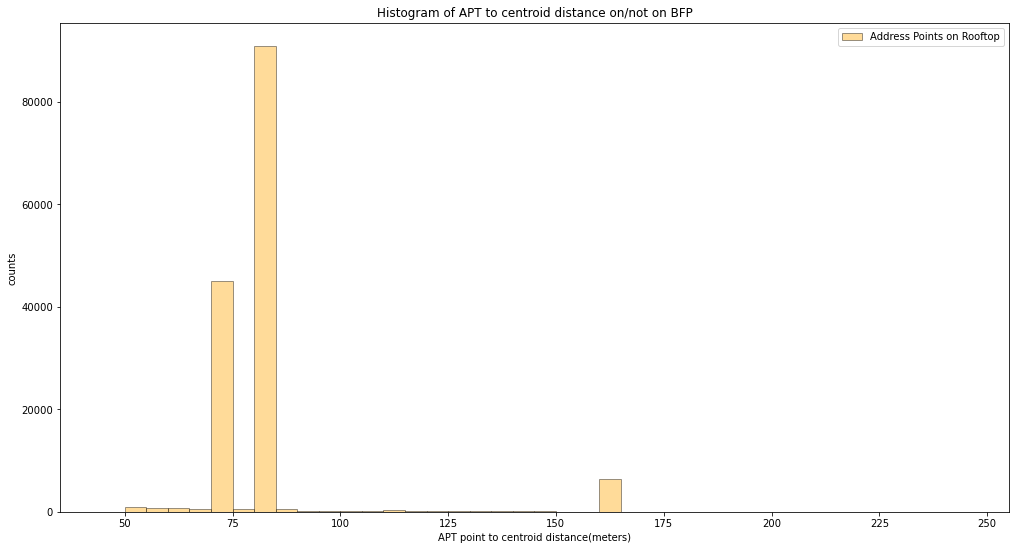

16

In [5]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_harris['APT_to_Centroid_distance'].loc[processed_df_harris['APT_to_Centroid_distance']>50].values, bins = np.arange(45,250,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [6]:
print(processed_df_harris.shape)
processed_df_harris[['updated_geometries','feat_id','postal_cod','house_numb','state_prov','locality','street_nam','country_co','prefix','suffix',
	                'predir','postdir','sn_body','APT_to_Centroid_distance','APT_lat','APT_lon','updated_lat',	'updated_lon']].head()

(1273681, 27)


,updated_geometries,feat_id,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
2,POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,77484,20520,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,189.5,30.071253,-95.906471,30.071464,-95.908425
3,POINT (-95.90843 30.07146),00005554-3500-2800-0000-000000f651bd,77484,20520,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,189.5,30.071253,-95.906471,30.071464,-95.908425
4,POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,77484,20550,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,285.2,30.071400,-95.905479,30.072056,-95.908343
5,POINT (-95.90834 30.07206),c9321b9f-1ba2-4190-8756-253a2bf07ca8,77484,20550,TX,Waller,Stokes Rd,USA,None,Rd,None,None,Stokes,285.2,30.071400,-95.905479,30.072056,-95.908343
16,POINT (-95.87934 30.11551),00005554-3500-2800-0000-000000f054e5,77484,23321,TX,Waller,Kickapoo Rd,USA,None,Rd,None,None,Kickapoo,261.9,30.117724,-95.880273,30.115511,-95.879343


In [8]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
if not os.path.isdir(output_path):
    os.makedirs(output_path,exist_ok=True)

df_for_analysis_usa_harris = processed_df_harris.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)

fname = os.path.join(output_path,"APT_realigned_usa_utx_Harris")
geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_harris, geometry='updated_geometries', crs="EPSG:4326")
pd_dataframe = pd.DataFrame(geo_dataframe)

pd_dataframe.to_pickle(fname+'.pkl')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=fname+'.shp')

